# Installs & Imports

In [1]:
!pip install --quiet pyro-ppl torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.0 MB/s eta 0:00:00


In [2]:
import os
import requests
from zipfile import ZipFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from datetime import timedelta
from scipy.stats import skew, kurtosis
import re
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.forecast import ForecastingModel, Forecaster, backtest, eval_crps
from pyro.infer.reparam import LocScaleReparam, StableReparam
from pyro.ops.tensor_utils import periodic_features
from pyro.ops.stats import quantile

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

pyro.set_rng_seed(123)
assert pyro.__version__.startswith('1.9.1')

# Data Loading

In [3]:
def download_bike_sharing_data(url, zip_filename, data_dir):
    # Download and unzip the bike sharing dataset if not already downloaded
    if not os.path.exists(data_dir):
        print("Downloading the dataset")
        response = requests.get(url)
        with open(zip_filename, 'wb') as file:
            file.write(response.content)
        print("Unzipping the dataset")
        with ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
        print("Dataset downloaded and unzipped")
    else:
        print("Dataset already downloaded and unzipped")

# URL of the Bike Sharing Dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
zip_filename = "Bike-Sharing-Dataset.zip"
data_dir = "Bike-Sharing-Dataset"

download_bike_sharing_data(url, zip_filename, data_dir)

Unzipping the dataset
Dataset downloaded and unzipped


In [4]:
# Load daily bike sharing data from day.csv
df_day = pd.read_csv(os.path.join(data_dir, "day.csv"))

# Convert dteday to datetime and sort the data
df_day['dteday'] = pd.to_datetime(df_day['dteday'])
df_day = df_day.sort_values('dteday')
print("Preview of the data:")
display(df_day.head(10))
print(f"\nShape of the data: {df_day.shape}")

Preview of the data:


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
5,6,2011-01-06,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.089565,88,1518,1606
6,7,2011-01-07,1,0,1,0,5,1,2,0.196522,0.208839,0.498696,0.168726,148,1362,1510
7,8,2011-01-08,1,0,1,0,6,0,2,0.165000,0.162254,0.535833,0.266804,68,891,959
8,9,2011-01-09,1,0,1,0,0,0,1,0.138333,0.116175,0.434167,0.361950,54,768,822
9,10,2011-01-10,1,0,1,0,1,1,1,0.150833,0.150888,0.482917,0.223267,41,1280,1321



Shape of the data: (731, 16)


# Data Exploration

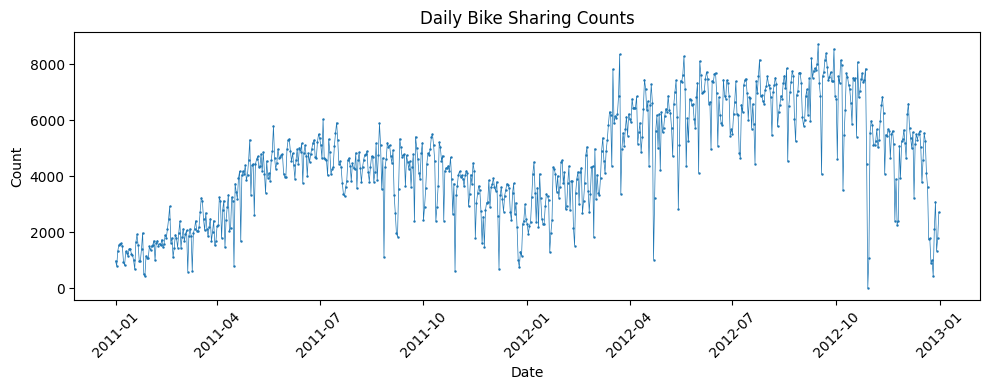

In [5]:
# Plot the daily counts over time
plt.figure(figsize=(10, 4))
plt.plot(
    df_day['dteday'],
    df_day['cnt'],
    marker='.',
    markersize=1.5,
    linestyle='-',
    linewidth=0.5
)
plt.title("Daily Bike Sharing Counts")
plt.xlabel("Date")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
# Zero counts
zero_counts = df_day[df_day['cnt'] == 0]
print("Number of days with zero counts:", len(zero_counts))

Number of days with zero counts: 0


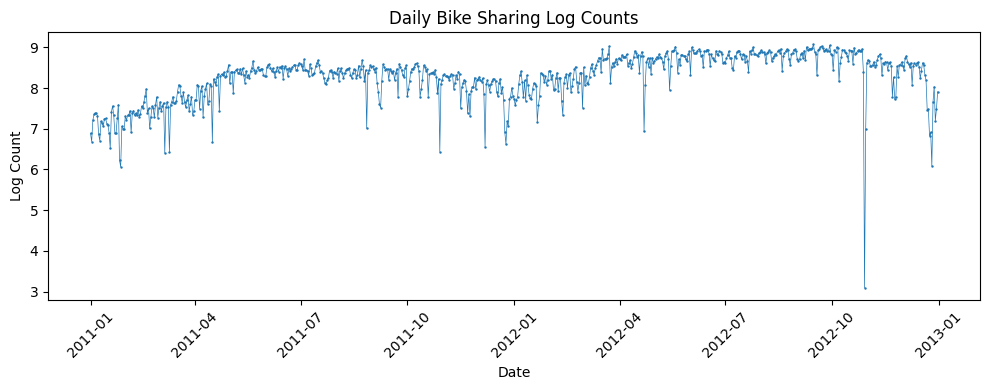

In [7]:
# Plot the daily log counts over time
plt.figure(figsize=(10, 4))
plt.plot(
    df_day['dteday'],
    np.log(df_day['cnt']),
    marker='.',
    markersize=1.5,
    linestyle='-',
    linewidth=0.5
)
plt.title("Daily Bike Sharing Log Counts")
plt.xlabel("Date")
plt.ylabel("Log Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
# Aggregate daily counts into monthly totals
df_day.set_index('dteday', inplace=True)
df_monthly = df_day['cnt'].resample('MS').sum().reset_index()
df_monthly.columns = ['Month', 'Count']

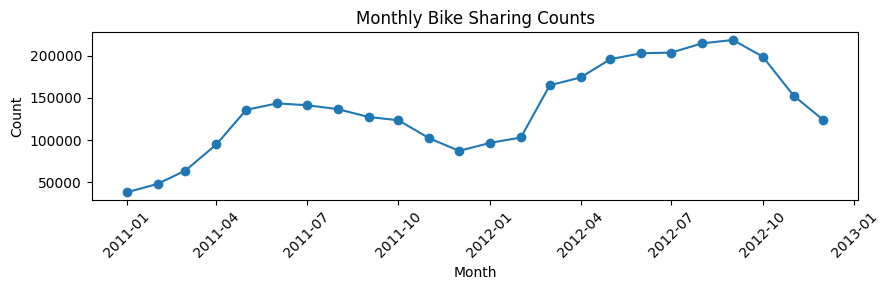

In [9]:
# Plot the monthly counts
plt.figure(figsize=(9, 3))
plt.plot(df_monthly['Month'], df_monthly['Count'], marker='o')
plt.title("Monthly Bike Sharing Counts")
plt.ylabel("Count")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

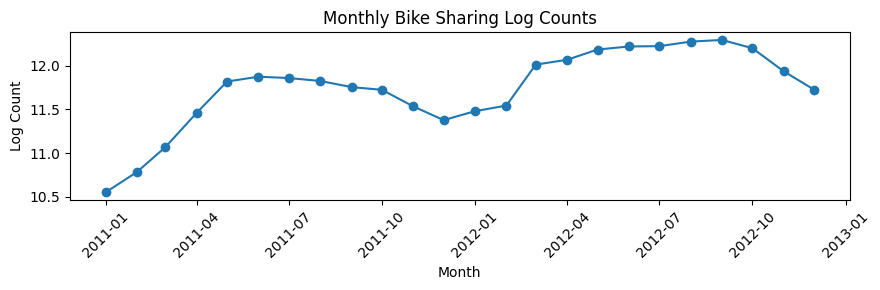

In [10]:
# Plot the monthly log counts
plt.figure(figsize=(9, 3))
plt.plot(df_monthly['Month'], np.log(df_monthly['Count']), marker='o')
plt.title("Monthly Bike Sharing Log Counts")
plt.ylabel("Log Count")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Data Preparation

In [11]:
# For modeling, use the log-transformed daily counts
daily_data = torch.tensor(np.log(df_day['cnt'].values), dtype=torch.float32).unsqueeze(-1)

In [12]:
# Define total number of days using the log-transformed daily data
total_days = daily_data.size(0)

# Use the last 30 days as the test set
train_end = total_days - 30

# Create training and test set objects
training_data = daily_data[:train_end]
test_data = daily_data[train_end:]

In [13]:
# View training data (log scale) descriptive statistics
mean_val = training_data.mean()
var_val = training_data.var()
std_val = training_data.std()
min_val = training_data.min()
max_val = training_data.max()

training_data_np = training_data.numpy().flatten()
skew_val = skew(training_data_np)
kurt_val = kurtosis(training_data_np)

print("Training Data Mean:", mean_val.item())
print("Training Data Variance:", var_val.item())
print("Training Data Std:", std_val.item())
print("Training Data Min:", min_val.item())
print("Training Data Max:", max_val.item())
print("Training Data Skew:", skew_val.item())
print("Training Data Kurtosis:", kurt_val.item())

Training Data Mean: 8.290571212768555
Training Data Variance: 0.33452627062797546
Training Data Std: 0.5783824920654297
Training Data Min: 3.0910425186157227
Training Data Max: 9.072686195373535
Training Data Skew: -1.9559799730587464
Training Data Kurtosis: 9.528543463593707


In [14]:
# # Annual periodic features: period = 365.25 days per cycle
# annual_covariates = periodic_features(total_days, 365.25)

# # Monthly periodic features: period = ~30.437 days per cycle
# monthly_covariates = periodic_features(total_days, 30.437)

# # Weekly periodic features: period = 7 days per cycle
# weekly_covariates = periodic_features(total_days, 7)

# # Concatenate all features along the last dimension
# full_covariates = torch.cat([annual_covariates, monthly_covariates, weekly_covariates], dim=-1)

In [15]:
# Create covariate features for the full daily data
full_covariates = periodic_features(total_days, 365.25)

In [16]:
# Split covariates into training and test sets
training_covariates = full_covariates[:train_end]
test_covariates = full_covariates[train_end:]

In [17]:
# Print shapes
print("Full Data Shape:", daily_data.shape)
print("Full Covariates Shape:", full_covariates.shape)
print("\nTraining Data Shape:", training_data.shape)
print("Training Covariates Shape:", training_covariates.shape)
print("\nTest Data Shape:", test_data.shape)
print("Test Covariates Shape:", test_covariates.shape)

Full Data Shape: torch.Size([731, 1])
Full Covariates Shape: torch.Size([731, 364])

Training Data Shape: torch.Size([701, 1])
Training Covariates Shape: torch.Size([701, 364])

Test Data Shape: torch.Size([30, 1])
Test Covariates Shape: torch.Size([30, 364])


In [18]:
def add_lagged_features(data, lags=[1]):
    """
    data: a tensor of shape (T, 1) representing the log counts.
    lags: list of integer lags to include.

    Returns a tensor of shape (T - max(lags), len(lags)) containing lagged features.
    """
    T, _ = data.shape
    max_lag = max(lags)
    lagged_features = []
    for lag in lags:
        # For each lag, drop the first `lag` rows and use data up to T - max_lag
        lagged = data[lag:T - (max_lag - lag)]
        lagged_features.append(lagged)
    # Concatenate lagged features along the feature dimension
    return torch.cat(lagged_features, dim=1)

In [19]:
# Calculate the maximum lag
lags = [1, 2, 3, 4, 5, 6, 7]
max_lag = max(lags)

In [20]:
# Create lagged features from the daily_data (log counts)
lagged_features = add_lagged_features(daily_data, lags=lags)
print("Lagged features shape:", lagged_features.shape)  # Expected shape: (T - max_lag, len(lags))

# Adjust the full_covariates and daily_data by dropping the first max_lag rows
full_covariates = full_covariates[max_lag:]
daily_data = daily_data[max_lag:]

print("Adjusted Daily Data Shape:", daily_data.shape)
print("Adjusted Full Covariates Shape:", full_covariates.shape)

# Concatenate the lagged features with the periodic covariates
full_covariates = torch.cat([full_covariates, lagged_features], dim=1)
print("Final Covariates Shape:", full_covariates.shape)

Lagged features shape: torch.Size([724, 7])
Adjusted Daily Data Shape: torch.Size([724, 1])
Adjusted Full Covariates Shape: torch.Size([724, 364])
Final Covariates Shape: torch.Size([724, 371])


In [21]:
# Define total number of days again
total_days = daily_data.size(0)

# Use the last 30 days as the test set
train_end = total_days - 30

# Re-split the data into training and test sets
training_data = daily_data[:train_end]
test_data = daily_data[train_end:]

In [22]:
# Re-split covariates into training and test sets
training_covariates = full_covariates[:train_end]
test_covariates = full_covariates[train_end:]

print("Training Data Shape:", training_data.shape)
print("Training Covariates Shape:", training_covariates.shape)
print("\nTest Data Shape:", test_data.shape)
print("Test Covariates Shape:", test_covariates.shape)

Training Data Shape: torch.Size([694, 1])
Training Covariates Shape: torch.Size([694, 371])

Test Data Shape: torch.Size([30, 1])
Test Covariates Shape: torch.Size([30, 371])


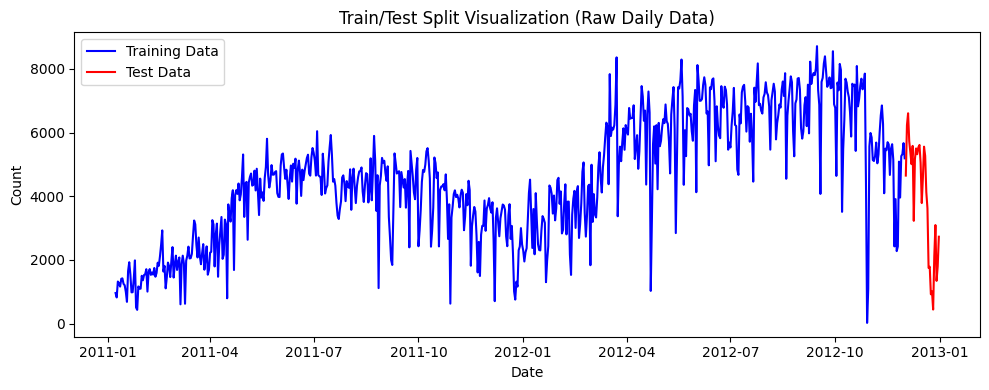

In [23]:
# Visualize the train/test split using the raw (non-log) daily counts
df_day = df_day.iloc[max_lag:]
train_X = df_day.index[:train_end]
train_y = np.exp(daily_data[:train_end].squeeze().numpy())

test_X = df_day.index[train_end:]
test_y = np.exp(daily_data[train_end:].squeeze().numpy())

plt.figure(figsize=(10, 4))
plt.plot(train_X, train_y, 'b-', label='Training Data')
plt.plot(test_X, test_y, 'r-', label='Test Data')
plt.title("Train/Test Split Visualization (Raw Daily Data)")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

# Model Definition

In [24]:
class StableForecastModel(ForecastingModel):
    def model(self, zero_data, covariates):
        # zero_data: observed log-transformed daily counts; shape = (T, 1)
        # covariates: daily covariate features; shape = (T, cov_dim)
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)

        # Compute the empirical mean of the training data
        data_mean = zero_data.mean()

        # Bias prior centered on the empirical mean, with a small variance
        bias = pyro.sample("bias", dist.Normal(data_mean, 0.5).expand([data_dim]).to_event(1))
        weight = pyro.sample("weight", dist.Normal(0, 0.1).expand([feature_dim]).to_event(1))

        # Center the training data for modeling drift
        zero_data_centered = zero_data - data_mean

        # Small drift scale prior for daily increments
        # With a mean around 8.29 and std ~0.58, daily changes are modest
        drift_scale = pyro.sample("drift_scale", dist.LogNormal(-12, 0.2).expand([1]).to_event(1))

        with self.time_plate:
            with poutine.reparam(config={"drift": LocScaleReparam()}):
                # Model daily drift increments on centered data
                drift = pyro.sample("drift", dist.Normal(zero_data_centered, drift_scale).to_event(1))

        # Build the daily Brownian motion (cumulative drift)
        motion = drift.cumsum(-2)

        # Covariate effects
        cov_effect = (weight * covariates).sum(-1, keepdim=True)

        # Combine drift, bias, and covariate effects, then add back the mean
        prediction = motion + bias + cov_effect + data_mean
        assert prediction.shape[-2:] == zero_data.shape

        # Define noise likelihood with a Stable distribution
        stability = pyro.sample("noise_stability", dist.Uniform(1, 2).expand([1]).to_event(1))
        skew = pyro.sample("noise_skew", dist.Uniform(-1, 1).expand([1]).to_event(1))
        scale = pyro.sample("noise_scale", dist.LogNormal(-5, 5).expand([1]).to_event(1))
        noise_dist = dist.Stable(stability, skew, scale)

        # Reparameterize the noise for the Stable distribution
        with poutine.reparam(config={"residual": StableReparam()}):
            self.predict(noise_dist, prediction)

In [25]:
# class StableForecastModel(ForecastingModel):
#     def model(self, zero_data, covariates):
#         # zero_data: observed log-transformed daily counts; shape = (T, 1)
#         # covariates: daily covariate features; shape = (T, cov_dim)
#         print("Input zero_data shape:", zero_data.shape)
#         print("Input covariates shape:", covariates.shape)

#         data_dim = zero_data.size(-1)
#         feature_dim = covariates.size(-1)
#         print("data_dim:", data_dim)
#         print("feature_dim:", feature_dim)

#         # Compute the empirical mean of the training data
#         data_mean = zero_data.mean()
#         print("data_mean:", data_mean)

#         # Bias prior centered on the empirical mean, with a small variance
#         bias = pyro.sample("bias", dist.Normal(data_mean, 0.5).expand([data_dim]).to_event(1))
#         weight = pyro.sample("weight", dist.Normal(0, 0.1).expand([feature_dim]).to_event(1))
#         print("bias shape:", bias.shape)
#         print("weight shape:", weight.shape)

#         # Center the training data for modeling drift
#         zero_data_centered = zero_data - data_mean
#         print("zero_data_centered shape:", zero_data_centered.shape)

#         # Small drift scale prior for daily increments
#         # With a mean around 8.29 and std ~0.58, daily changes are modest
#         drift_scale = pyro.sample("drift_scale", dist.LogNormal(-12, 0.2).expand([1]).to_event(1))
#         print("drift_scale shape:", drift_scale.shape)

#         with self.time_plate:
#             with poutine.reparam(config={"drift": LocScaleReparam()}):
#                 # Model daily drift increments on centered data
#                 drift = pyro.sample("drift", dist.Normal(zero_data_centered, drift_scale).to_event(1))
#         print("drift shape:", drift.shape)

#         # Build the daily Brownian motion (cumulative drift)
#         motion = drift.cumsum(-2)
#         print("motion shape:", motion.shape)

#         # Covariate effects
#         cov_effect = (weight * covariates).sum(-1, keepdim=True)
#         print("cov_effect shape:", cov_effect.shape)

#         # Combine drift, bias, and covariate effects, then add back the mean
#         prediction = motion + bias + cov_effect + data_mean
#         print("prediction shape:", prediction.shape)
#         assert prediction.shape[-2:] == zero_data.shape

#         # Define noise likelihood with a Stable distribution
#         stability = pyro.sample("noise_stability", dist.Uniform(1, 2).expand([1]).to_event(1))
#         skew = pyro.sample("noise_skew", dist.Uniform(-1, 1).expand([1]).to_event(1))
#         scale = pyro.sample("noise_scale", dist.LogNormal(-5, 5).expand([1]).to_event(1))
#         noise_dist = dist.Stable(stability, skew, scale)

#         print("stability shape:", stability.shape)
#         print("skew shape:", skew.shape)
#         print("scale shape:", scale.shape)
#         print("noise_dist:", noise_dist)

#         # Reparameterize the noise for the Stable distribution
#         with poutine.reparam(config={"residual": StableReparam()}):
#             self.predict(noise_dist, prediction)

In [26]:
class SklearnStableForecastRegressor:
    """
    A scikit-learn–compatible regressor that wraps a StableForecastModel.

    Methods:
      - fit(y, covariates):
            Fits the model using training data y (log-transformed, shape (T_train, 1))
            and associated covariates (shape (T_train, cov_dim)).
      - predict(test_covariates, prediction_type, quantiles, n_samples, log_transformation):
            Constructs a full covariate sequence by concatenating the training_covariates
            with the test_covariates provided here.
            Returns predictions for the out-of-sample horizon (i.e. for the test period).
            Predictions are in log scale by default; if log_transformation=True, applies
            torch.exp() to return forecasts on the original scale.
            Prediction_type options:
              "mean": returns the mean forecast (shape: (T_test, 1)).
              "median": returns the median forecast (shape: (T_test, 1)).
              "samples": returns all prediction samples (shape: (n_samples, T_test, 1)).
              "quantiles": returns quantile forecasts (shape: (n_quantiles, T_test)).
      - set_params(**params): Sets model parameters.
      - get_params(deep): Returns a dictionary of parameters.
      - score(test_covariates, test_data, n_samples, samples):
            Scores the model on test_data using predictions generated from the full covariate
            sequence constructed internally.
            If samples=False (default): returns negative MAE from the mean forecast (after inverse transformation).
            If samples=True: returns negative CRPS computed from prediction samples (after inverse transformation).

    Note: This regressor trains on log-transformed data and returns forecasts in log scale by default.
    Use the log_transformation argument in predict() to obtain forecasts on the original scale.
    """

    def __init__(self, learning_rate=0.1, time_reparam="dct", num_steps=1001, log_every=100, n_samples=1000, batch_size=None, **kwargs):
        self.learning_rate = learning_rate
        self.time_reparam = time_reparam
        self.num_steps = num_steps
        self.log_every = log_every
        self.n_samples = n_samples
        if batch_size is not None:
            self.batch_size = batch_size
        else:
            self.batch_size = n_samples
        self.fitted = False
        self.forecaster = None
        self.training_data = None
        self.training_covariates = None
        self.params = kwargs

    def fit(self, y, covariates):
        """
        Fit the model using training data y (torch tensor of shape (T_train, 1); log-transformed)
        and covariates (torch tensor of shape (T_train, cov_dim)).
        """
        self.training_data = y
        self.training_covariates = covariates
        self.forecaster = Forecaster(
            StableForecastModel(),
            y,
            covariates,
            learning_rate=self.learning_rate,
            time_reparam=self.time_reparam,
            num_steps=self.num_steps,
            log_every=self.log_every
        )
        # Run a quick pass to initialize parameters
        _ = self.forecaster(y, covariates, num_samples=self.n_samples)
        self.fitted = True
        return self

    def predict(self, test_covariates, prediction_type="mean", quantiles=None, n_samples=None, log_transformation=False):
        """
        Predict using the fitted model given test covariates.

        Internally, this method constructs a full covariates tensor by concatenating the training_covariates
        (from the fit() call) with the test_covariates provided here.

        The forecaster then returns forecasts for the out-of-sample horizon (i.e. for the test period).

        Prediction_type options:
            "mean": returns the mean forecast (out-of-sample) [shape: (T_test, 1)].
            "median": returns the median forecast (out-of-sample) [shape: (T_test, 1)].
            "samples": returns all prediction samples (out-of-sample) [shape: (n_samples, T_test, 1)].
            "quantiles": returns quantile forecasts (out-of-sample) [shape: (n_quantiles, T_test)].

        If log_transformation=True, applies torch.exp() to inverse transform forecasts to the original scale.
        """
        if not self.fitted:
            raise ValueError("Model is not fitted yet. Please call fit() first")
        if n_samples is None:
            n_samples = self.n_samples

        # Construct full covariates by concatenating training and test covariates
        full_covariates = torch.cat([self.training_covariates, test_covariates], dim=0)

        # Obtain forecast_samples
        # forecast_samples shape: (n_samples, T_test, 1)
        forecast_samples = self.forecaster(self.training_data, full_covariates, num_samples=n_samples)

        # Apply inverse transformation of log-scale results if requested
        if log_transformation:
            forecast_samples = torch.exp(forecast_samples)

        if prediction_type == "mean":
            return forecast_samples.mean(dim=0)
        elif prediction_type == "median":
            return torch.median(forecast_samples, dim=0)[0]
        elif prediction_type == "samples":
            return forecast_samples
        elif prediction_type == "quantiles":
            if quantiles is None:
                raise ValueError("For 'quantiles', provide a list of quantiles")
            return quantile(forecast_samples, quantiles)
        else:
            raise ValueError("Unknown prediction_type: {}".format(prediction_type))

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
            self.params[key] = value
        return self

    def get_params(self, deep=True):
        return self.params

    def score(self, test_covariates, test_data, n_samples=None, samples=False):
        """
        Score the model on test_data using predictions generated from test_covariates.

        Internally, the test_covariates are concatenated with the training_covariates
        to form the full covariate sequence.

        If samples=False (default): returns negative MAE from the mean forecast (after inverse transformation).
        If samples=True: returns negative CRPS computed from prediction samples (after inverse transformation).

        Note: test_data is expected to be in log scale.
        """
        if n_samples is None:
            n_samples = self.n_samples

        full_covariates = torch.cat([self.training_covariates, test_covariates], dim=0)
        forecast_samples = self.forecaster(self.training_data, full_covariates, num_samples=n_samples)
        if samples:
            score_val = -eval_crps(torch.exp(forecast_samples), torch.exp(test_data))
        else:
            mean_forecasts = forecast_samples.mean(dim=0)
            score_val = -torch.abs(torch.exp(mean_forecasts) - torch.exp(test_data)).mean().item()
        return score_val

# Model Fitting

In [27]:
# Create an instance of the scikit-learn–compatible regressor
sk_model = SklearnStableForecastRegressor(
    learning_rate=0.1,
    time_reparam="dct",
    num_steps=20001,
    log_every=500,
    n_samples=1000
)

# Fit the model with training data and training covariates
sk_model.fit(training_data, training_covariates)

INFO:pyro.contrib.forecast.forecaster:step    0 loss = 919.461
INFO:pyro.contrib.forecast.forecaster:step  500 loss = 2.38268
INFO:pyro.contrib.forecast.forecaster:step 1000 loss = 3.1671
INFO:pyro.contrib.forecast.forecaster:step 1500 loss = 2.39827
INFO:pyro.contrib.forecast.forecaster:step 2000 loss = 2.52359
INFO:pyro.contrib.forecast.forecaster:step 2500 loss = 2.36103
INFO:pyro.contrib.forecast.forecaster:step 3000 loss = 2.88661
INFO:pyro.contrib.forecast.forecaster:step 3500 loss = 2.10758
INFO:pyro.contrib.forecast.forecaster:step 4000 loss = 2.51229
INFO:pyro.contrib.forecast.forecaster:step 4500 loss = 2.13342
INFO:pyro.contrib.forecast.forecaster:step 5000 loss = 1.87414
INFO:pyro.contrib.forecast.forecaster:step 5500 loss = 2.00278
INFO:pyro.contrib.forecast.forecaster:step 6000 loss = 2.03358
INFO:pyro.contrib.forecast.forecaster:step 6500 loss = 2.17442
INFO:pyro.contrib.forecast.forecaster:step 7000 loss = 2.01331
INFO:pyro.contrib.forecast.forecaster:step 7500 loss = 1

In [56]:
# Assign the output to a log string object
log_string = """
INFO:pyro.contrib.forecast.forecaster:step    0 loss = 919.461
INFO:pyro.contrib.forecast.forecaster:step  500 loss = 2.38268
INFO:pyro.contrib.forecast.forecaster:step 1000 loss = 3.1671
INFO:pyro.contrib.forecast.forecaster:step 1500 loss = 2.39827
INFO:pyro.contrib.forecast.forecaster:step 2000 loss = 2.52359
INFO:pyro.contrib.forecast.forecaster:step 2500 loss = 2.36103
INFO:pyro.contrib.forecast.forecaster:step 3000 loss = 2.88661
INFO:pyro.contrib.forecast.forecaster:step 3500 loss = 2.10758
INFO:pyro.contrib.forecast.forecaster:step 4000 loss = 2.51229
INFO:pyro.contrib.forecast.forecaster:step 4500 loss = 2.13342
INFO:pyro.contrib.forecast.forecaster:step 5000 loss = 1.87414
INFO:pyro.contrib.forecast.forecaster:step 5500 loss = 2.00278
INFO:pyro.contrib.forecast.forecaster:step 6000 loss = 2.03358
INFO:pyro.contrib.forecast.forecaster:step 6500 loss = 2.17442
INFO:pyro.contrib.forecast.forecaster:step 7000 loss = 2.01331
INFO:pyro.contrib.forecast.forecaster:step 7500 loss = 1.92287
INFO:pyro.contrib.forecast.forecaster:step 8000 loss = 1.64437
INFO:pyro.contrib.forecast.forecaster:step 8500 loss = 1.72731
INFO:pyro.contrib.forecast.forecaster:step 9000 loss = 1.72603
INFO:pyro.contrib.forecast.forecaster:step 9500 loss = 2.2342
INFO:pyro.contrib.forecast.forecaster:step 10000 loss = 2.31175
INFO:pyro.contrib.forecast.forecaster:step 10500 loss = 1.50306
INFO:pyro.contrib.forecast.forecaster:step 11000 loss = 1.72717
INFO:pyro.contrib.forecast.forecaster:step 11500 loss = 1.51156
INFO:pyro.contrib.forecast.forecaster:step 12000 loss = 1.50202
INFO:pyro.contrib.forecast.forecaster:step 12500 loss = 1.51969
INFO:pyro.contrib.forecast.forecaster:step 13000 loss = 1.5191
INFO:pyro.contrib.forecast.forecaster:step 13500 loss = 1.56599
INFO:pyro.contrib.forecast.forecaster:step 14000 loss = 1.56343
INFO:pyro.contrib.forecast.forecaster:step 14500 loss = 1.65942
INFO:pyro.contrib.forecast.forecaster:step 15000 loss = 1.82007
INFO:pyro.contrib.forecast.forecaster:step 15500 loss = 1.49538
INFO:pyro.contrib.forecast.forecaster:step 16000 loss = 1.28302
INFO:pyro.contrib.forecast.forecaster:step 16500 loss = 1.34471
INFO:pyro.contrib.forecast.forecaster:step 17000 loss = 1.791
INFO:pyro.contrib.forecast.forecaster:step 17500 loss = 1.24808
INFO:pyro.contrib.forecast.forecaster:step 18000 loss = 1.21819
INFO:pyro.contrib.forecast.forecaster:step 18500 loss = 1.17598
INFO:pyro.contrib.forecast.forecaster:step 19000 loss = 1.52278
INFO:pyro.contrib.forecast.forecaster:step 19500 loss = 1.48139
INFO:pyro.contrib.forecast.forecaster:step 20000 loss = 1.20401
"""

In [59]:
def plot_loss(log_string, log_scale=False, skip_points=0):
    """
    Parse log_string for 'step X loss = Y' lines and plot them.

    :param log_string: str, captured logs containing step/loss info
    :param log_scale: bool, if True uses a logarithmic scale for the y-axis
    :param skip_points: int, number of initial data points to skip
    """
    # Define a regex pattern to capture the step number and loss value
    pattern = r"step\s+(\d+).*loss\s*=\s*([\d\.]+)"
    matches = re.findall(pattern, log_string)

    if not matches:
        print("No valid data found in the log string.")
        return

    # Convert the extracted string values to integers and floats
    steps = [int(m[0]) for m in matches]
    losses = [float(m[1]) for m in matches]

    # Skip the first N points if requested
    steps = steps[skip_points:]
    losses = losses[skip_points:]

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(steps, losses, marker='o', linestyle='-', color='b')

    # Use log scale on the y-axis
    if log_scale:
        plt.yscale('log')
        plt.ylabel("Loss (log scale)")
    else:
        plt.ylabel("Loss")

    plt.xlabel("Step")
    plt.title("Loss Over Steps")
    plt.grid(True)
    plt.show()

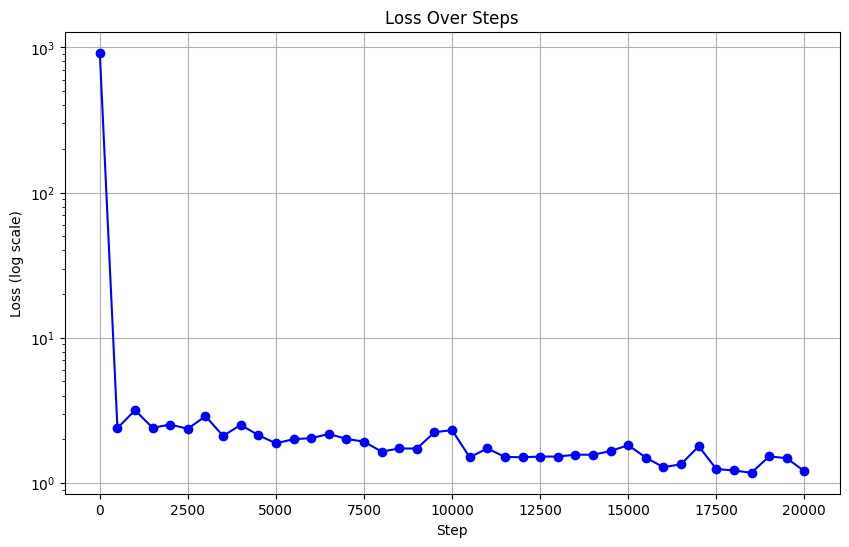

In [61]:
# Plot the loss
plot_loss(log_string, log_scale=True)

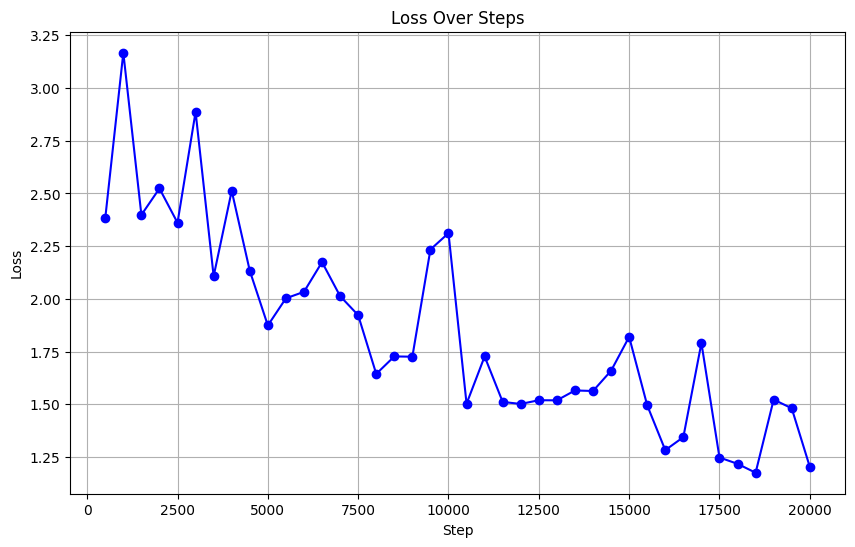

In [62]:
# Plot the loss
plot_loss(log_string, skip_points=1)

In [31]:
pyro.set_rng_seed(1234)
pyro.clear_param_store()

# Print some guide parameters from the underlying forecaster
for param_name, param_value in sk_model.forecaster.guide.median().items():
    if param_value.numel() == 1:
        print("{} = {:0.4g}".format(param_name, param_value.item()))

bias = 0.2158
drift_scale = 6.076e-06
noise_stability = 1.995
noise_skew = 0.004948
noise_scale = 0.1626


# Model Predictions

In [32]:
# Obtain mean predictions on the original scale
mean_pred = sk_model.predict(
    test_covariates,
    prediction_type="mean",
    log_transformation=True
)
print("Mean Predictions Shape:", mean_pred.shape)

Mean Predictions Shape: torch.Size([30, 1])


In [33]:
# Obtain median predictions on the original scale
median_pred = sk_model.predict(
    test_covariates,
    prediction_type="median",
    log_transformation=True
)
print("Median Predictions Shape:", median_pred.shape)

Median Predictions Shape: torch.Size([30, 1])


In [34]:
# Obtain quantile predictions on the original scale
quantiles_pred = sk_model.predict(
    test_covariates,
    prediction_type="quantiles",
    quantiles=[0.1, 0.5, 0.9],
    log_transformation=True
)
print("Quantile Predictions Shape:", quantiles_pred.shape)

Quantile Predictions Shape: torch.Size([3, 30, 1])


In [35]:
# Separate the quantile predictions
quantiles_pred_10 = quantiles_pred[0]
quantiles_pred_50 = quantiles_pred[1]
quantiles_pred_90 = quantiles_pred[2]

print("10th Quantile Predictions Shape:", quantiles_pred_10.shape)
print("50th Quantile Predictions Shape:", quantiles_pred_50.shape)
print("90th Quantile Predictions Shape:", quantiles_pred_90.shape)

10th Quantile Predictions Shape: torch.Size([30, 1])
50th Quantile Predictions Shape: torch.Size([30, 1])
90th Quantile Predictions Shape: torch.Size([30, 1])


In [36]:
# Obtain sample predictions on the original scale
samples_pred = sk_model.predict(
    test_covariates,
    prediction_type="samples",
    log_transformation=True
)
print("Sample Predictions Shape:", samples_pred.shape)

Sample Predictions Shape: torch.Size([1000, 30, 1])


# Metrics Evaluation

In [37]:
# Define the true data
true_data = torch.tensor(df_day['cnt'].values, dtype=torch.float32).unsqueeze(-1)
print("True Data Shape:", true_data.shape)

# Define the true test data
true_test = true_data[train_end:]
print("True Test Data Shape:", true_test.shape)

True Data Shape: torch.Size([724, 1])
True Test Data Shape: torch.Size([30, 1])


In [38]:
# Compute CRPS
crps = eval_crps(samples_pred, true_test)
print("CRPS:", crps)

CRPS: 430.8974609375


In [39]:
# Ensure the prediction objects are flat vectors
mean_pred_flat = mean_pred.squeeze(-1)
median_pred_flat = median_pred.squeeze(-1)
quantiles_pred_10_flat = quantiles_pred_10.squeeze(-1)
quantiles_pred_50_flat = quantiles_pred_50.squeeze(-1)
quantiles_pred_90_flat = quantiles_pred_90.squeeze(-1)

print("Mean Predictions Shape:", mean_pred_flat.shape)
print("Median Predictions Shape:", median_pred_flat.shape)
print("10th Quantile Predictions Shape:", quantiles_pred_10_flat.shape)
print("50th Quantile Predictions Shape:", quantiles_pred_50_flat.shape)
print("90th Quantile Predictions Shape:", quantiles_pred_90_flat.shape)

Mean Predictions Shape: torch.Size([30])
Median Predictions Shape: torch.Size([30])
10th Quantile Predictions Shape: torch.Size([30])
50th Quantile Predictions Shape: torch.Size([30])
90th Quantile Predictions Shape: torch.Size([30])


In [40]:
# Ensure true test data is a flat vector
true_test_flat = true_test.squeeze(-1)
print("True Test Data Shape:", true_test_flat.shape)

True Test Data Shape: torch.Size([30])


In [41]:
# Convert prediction objects to numpy
mean_pred_np = mean_pred_flat.numpy()
median_pred_np = median_pred_flat.numpy()
quantiles_pred_10_np = quantiles_pred_10_flat.numpy()
quantiles_pred_50_np = quantiles_pred_50_flat.numpy()
quantiles_pred_90_np = quantiles_pred_90_flat.numpy()

print("Mean Predictions Shape:", mean_pred_np.shape)
print("Median Predictions Shape:", median_pred_np.shape)
print("10th Quantile Predictions Shape:", quantiles_pred_10_np.shape)
print("50th Quantile Predictions Shape:", quantiles_pred_50_np.shape)
print("90th Quantile Predictions Shape:", quantiles_pred_90_np.shape)

Mean Predictions Shape: (30,)
Median Predictions Shape: (30,)
10th Quantile Predictions Shape: (30,)
50th Quantile Predictions Shape: (30,)
90th Quantile Predictions Shape: (30,)


In [42]:
# Convert true test data to numpy
true_test_np = true_test_flat.numpy()
print("True Test Data Shape:", true_test_np.shape)

True Test Data Shape: (30,)


In [43]:
# Compute additional metrics - mean
rmse_mean = np.sqrt(np.mean((mean_pred_np - true_test_np) ** 2))
mae_mean = np.mean(np.abs(mean_pred_np - true_test_np))
mape_mean = np.mean(np.abs((mean_pred_np - true_test_np) / true_test_np)) * 100
smape_mean = np.mean(2 * np.abs(mean_pred_np - true_test_np) / (np.abs(true_test_np) + np.abs(mean_pred_np))) * 100

print("RMSE_mean:", rmse_mean)
print("MAE_mean:", mae_mean)
print("MAPE_mean:", mape_mean)
print("sMAPE_mean:", smape_mean)

RMSE_mean: 873.03955
MAE_mean: 668.50916
MAPE_mean: 18.83009970188141
sMAPE_mean: 16.717585921287537


In [44]:
# Compute additional metrics - median
rmse_median = np.sqrt(np.mean((median_pred_np - true_test_np) ** 2))
mae_median = np.mean(np.abs(median_pred_np - true_test_np))
mape_median = np.mean(np.abs((median_pred_np - true_test_np) / true_test_np)) * 100
smape_median = np.mean(2 * np.abs(median_pred_np - true_test_np) / (np.abs(true_test_np) + np.abs(median_pred_np))) * 100

print("RMSE_median:", rmse_median)
print("MAE_median:", mae_median)
print("MAPE_median:", mape_median)
print("sMAPE_median:", smape_median)

RMSE_median: 686.04175
MAE_median: 525.0183
MAPE_median: 15.294711291790009
sMAPE_median: 13.967950642108917


In [45]:
# Create metrics dictionary
metrics_dict = {
    'CRPS': crps,
    'RMSE_mean': rmse_mean,
    'MAE_mean': mae_mean,
    'MAPE_mean': mape_mean,
    'sMAPE_mean': smape_mean,
    'RMSE_median': rmse_median,
    'MAE_median': mae_median,
    'MAPE_median': mape_median,
    'sMAPE_median': smape_median
}

# Convert to DataFrame
df_metrics = pd.DataFrame([metrics_dict])

# Transpose, set column to 'Scores', and set index to 'Metric'
df_metrics = df_metrics.T
df_metrics.columns = ['Scores']
df_metrics.index.name = 'Metric'

# Display the DataFrame
display(df_metrics)

,Scores
Metric,
CRPS,430.897461
RMSE_mean,873.039551
MAE_mean,668.509155
MAPE_mean,18.830100
sMAPE_mean,16.717586
RMSE_median,686.041748
MAE_median,525.018311
MAPE_median,15.294711
sMAPE_median,13.967951


# Forecast Plotting

In [46]:
def plot_forecast(
    x_test,
    true_test,
    forecast,
    lower_bound,
    upper_bound,
    forecast_label="Mean Forecast",
    title="Daily Bike Sharing Forecast vs. True Data",
    xlabel="Day",
    ylabel="Count"
):
    """
    Plots the forecast with uncertainty bounds versus the true test data.

    Parameters:
      x_test (array-like): x-axis values for the test period.
      true_test (array-like): True test data values.
      forecast (array-like): Forecast values (e.g., mean or median).
      lower_bound (array-like): Lower bound of the prediction interval (e.g., 10th quantile).
      upper_bound (array-like): Upper bound of the prediction interval (e.g., 90th quantile).
      forecast_label (str): Label for the forecast line (default "Mean Forecast").
      title (str): Plot title.
      xlabel (str): Label for x-axis.
      ylabel (str): Label for y-axis.
    """
    plt.figure(figsize=(10, 5))
    plt.fill_between(x_test, lower_bound, upper_bound, color='salmon', alpha=0.3, label='90% Prediction Interval')
    plt.plot(x_test, forecast, 'r-', lw=1.5, marker='o', label=forecast_label)
    plt.plot(x_test, true_test, 'k-', lw=1.5, marker='o', label='True Data')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc="best")
    plt.show()

In [47]:
# Create an x-axis for the full daily series and for the test period
x_full = np.arange(total_days)
x_test = x_full[train_end:]

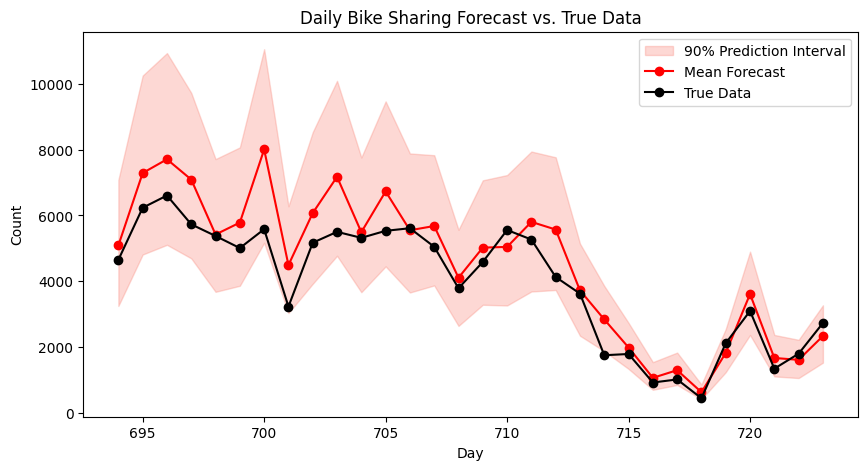

In [48]:
# Plot using the mean forecast
plot_forecast(
    x_test,
    true_test_np,
    mean_pred_np,
    quantiles_pred_10_np,
    quantiles_pred_90_np,
    forecast_label="Mean Forecast",
    title="Daily Bike Sharing Forecast vs. True Data"
)

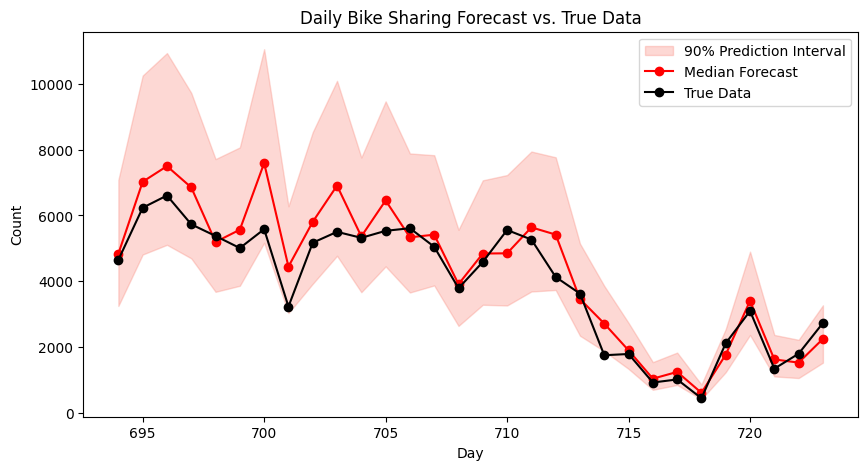

In [49]:
# Plot using the median forecast
plot_forecast(
    x_test,
    true_test_np,
    quantiles_pred_50_np,
    quantiles_pred_10_np,
    quantiles_pred_90_np,
    forecast_label="Median Forecast",
    title="Daily Bike Sharing Forecast vs. True Data"
)

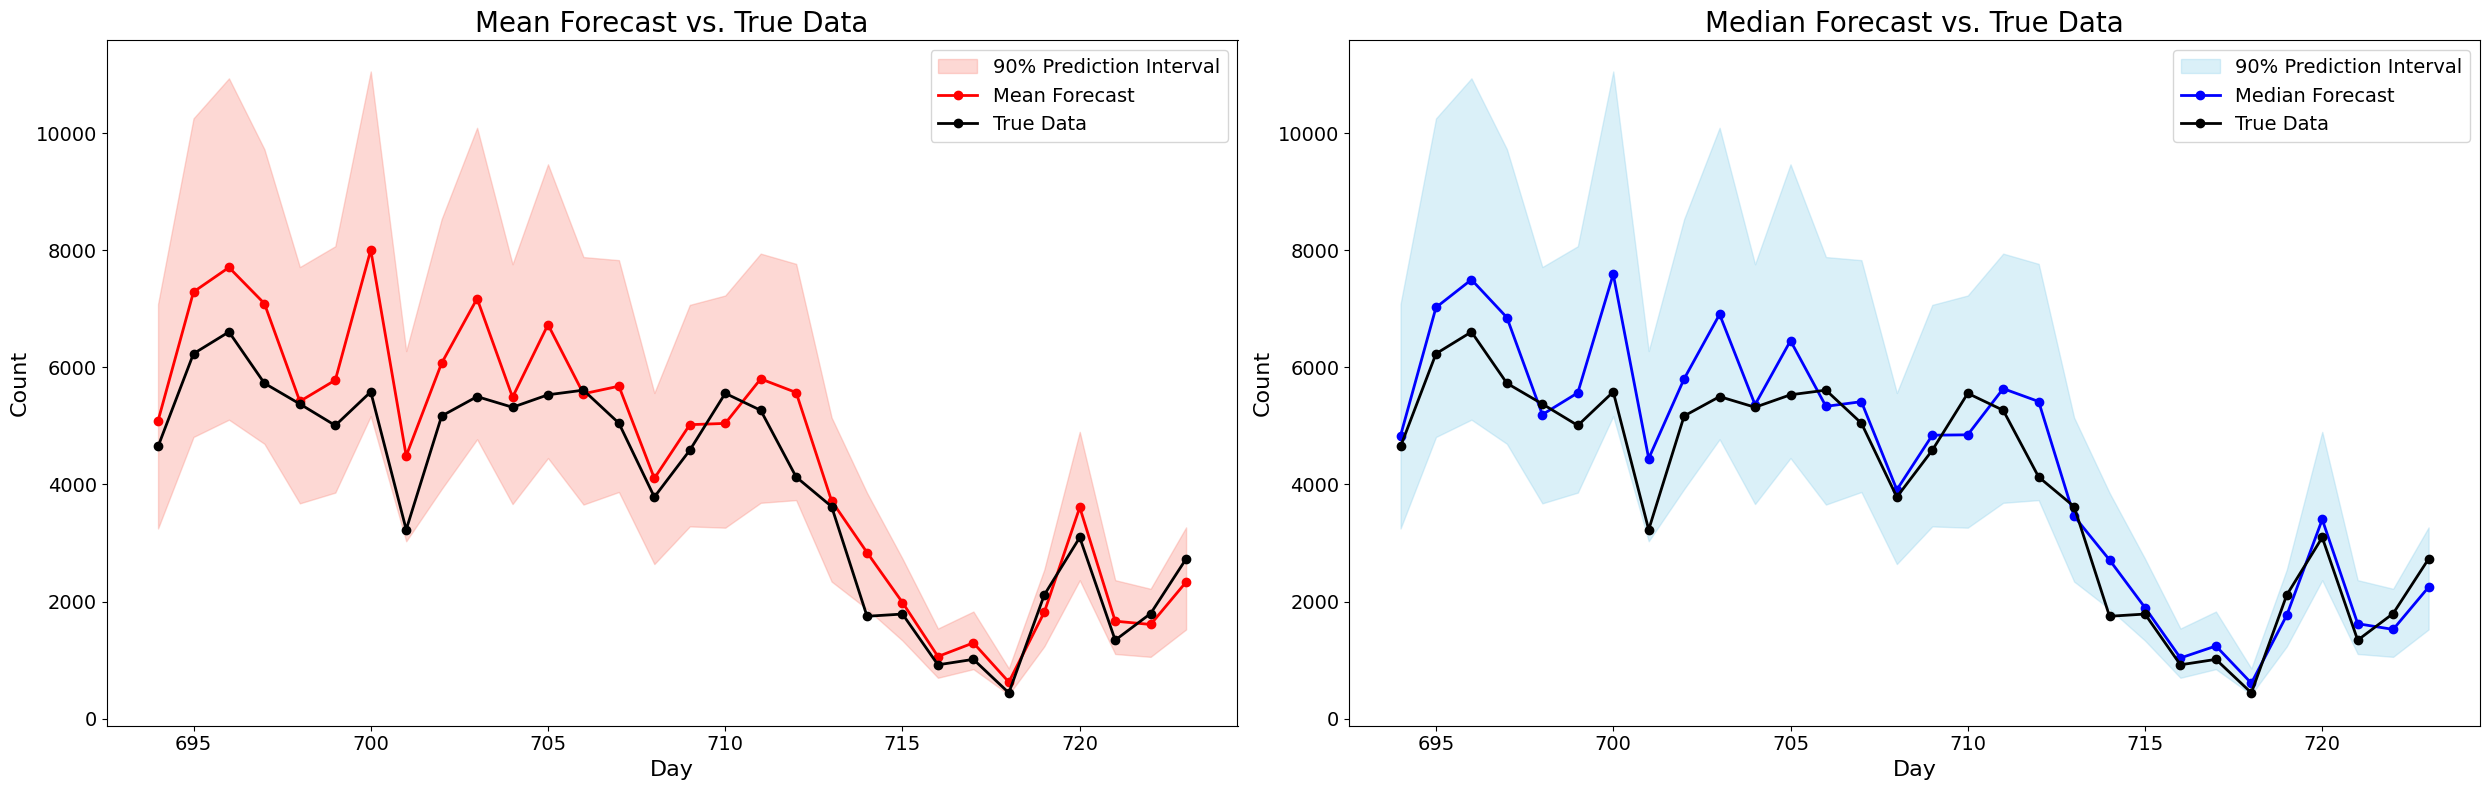

In [50]:
# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(25, 8))

# Left plot: Mean forecast vs. True Data
axes[0].fill_between(
    x_test,
    quantiles_pred_10_np,
    quantiles_pred_90_np,
    color='salmon',
    alpha=0.3,
    label='90% Prediction Interval'
)
axes[0].plot(x_test, mean_pred_np, 'r-', lw=2, marker='o', label='Mean Forecast')
axes[0].plot(x_test, true_test_np, 'k-', lw=2, marker='o', label='True Data')
axes[0].set_xlabel("Day", fontsize=16)
axes[0].set_ylabel("Count", fontsize=16)
axes[0].set_title("Mean Forecast vs. True Data", fontsize=20)
axes[0].legend(loc="best", fontsize=14)
axes[0].tick_params(axis='both', labelsize=14)

# Right plot: Median forecast vs. True Data
axes[1].fill_between(
    x_test,
    quantiles_pred_10_np,
    quantiles_pred_90_np,
    color='skyblue',
    alpha=0.3,
    label='90% Prediction Interval'
)
axes[1].plot(x_test, quantiles_pred_50_np, 'b-', lw=2, marker='o', label='Median Forecast')
axes[1].plot(x_test, true_test_np, 'k-', lw=2, marker='o', label='True Data')
axes[1].set_xlabel("Day", fontsize=16)
axes[1].set_ylabel("Count", fontsize=16)
axes[1].set_title("Median Forecast vs. True Data", fontsize=20)
axes[1].legend(loc="best", fontsize=14)
axes[1].tick_params(axis='both', labelsize=14)

plt.tight_layout()
plt.show()

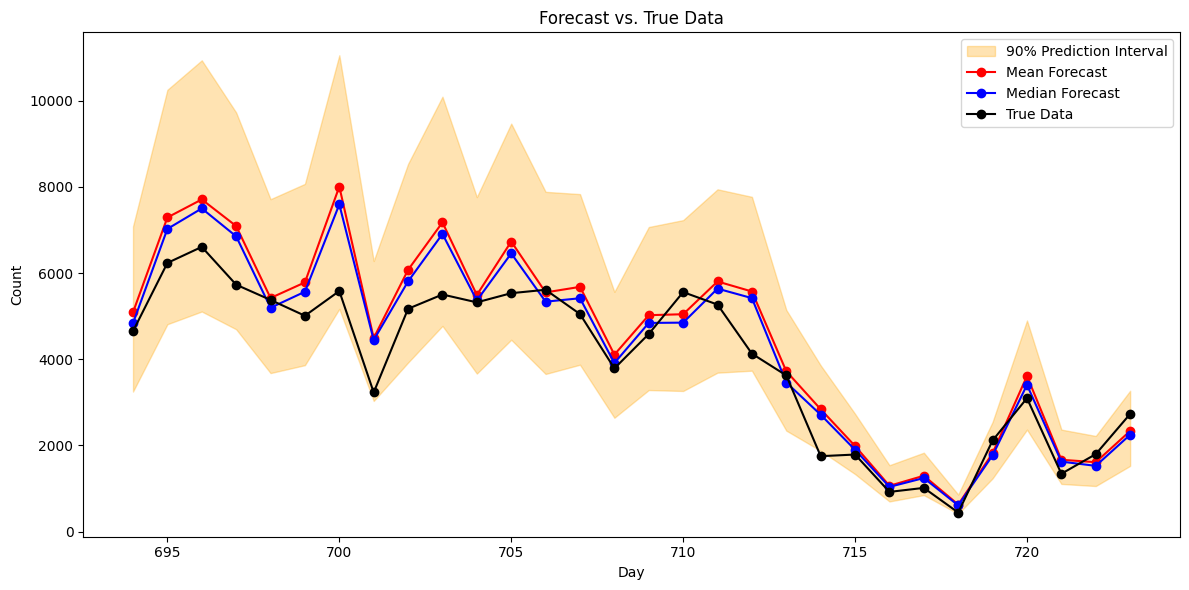

In [51]:
# Create a figure to plot both types of predictions
fig, ax = plt.subplots(figsize=(12, 6))

# Fill the 90% prediction interval
ax.fill_between(
    x_test,
    quantiles_pred_10_np,
    quantiles_pred_90_np,
    color='orange',
    alpha=0.3,
    label='90% Prediction Interval'
)

# Plot the mean forecast
ax.plot(x_test, mean_pred_np, 'r-', lw=1.5, marker='o', label='Mean Forecast')

# Plot the median forecast
ax.plot(x_test, quantiles_pred_50_np, 'b-', lw=1.5, marker='o', label='Median Forecast')

# Plot the true test data
ax.plot(x_test, true_test_np, 'k-', lw=1.5, marker='o', label='True Data')

# Set labels and title
ax.set_xlabel("Day")
ax.set_ylabel("Count")
ax.set_title("Forecast vs. True Data")
ax.legend(loc="best")
ax.tick_params(axis='both')

plt.tight_layout()
plt.show()

# Model Backtesting

In [52]:
pyro.set_rng_seed(12345)
pyro.clear_param_store()

# Backtest the model using the full daily data (log scale) and covariates
backtest_results = backtest(
    daily_data,
    full_covariates,
    StableForecastModel,
    min_train_window=400,
    test_window=30,
    stride=15,
    forecaster_options={
        "learning_rate": 0.1,
        "time_reparam": "dct",
        "log_every": 1000,
        "warm_start": True
    }
)

INFO:pyro.contrib.forecast.evaluate:Training on window [0:400], testing on window [400:430]
INFO:pyro.contrib.forecast.forecaster:step    0 loss = 5.92282e+08
INFO:pyro.contrib.forecast.forecaster:step 1000 loss = 1.85766
INFO:pyro.contrib.forecast.evaluate:Training on window [0:415], testing on window [415:445]
INFO:pyro.contrib.forecast.forecaster:step    0 loss = 2.19653
INFO:pyro.contrib.forecast.forecaster:step 1000 loss = 1.76517
INFO:pyro.contrib.forecast.evaluate:Training on window [0:430], testing on window [430:460]
INFO:pyro.contrib.forecast.forecaster:step    0 loss = 2.09926
INFO:pyro.contrib.forecast.forecaster:step 1000 loss = 1.69011
INFO:pyro.contrib.forecast.evaluate:Training on window [0:445], testing on window [445:475]
INFO:pyro.contrib.forecast.forecaster:step    0 loss = 2.00088
INFO:pyro.contrib.forecast.forecaster:step 1000 loss = 1.74812
INFO:pyro.contrib.forecast.evaluate:Training on window [0:460], testing on window [460:490]
INFO:pyro.contrib.forecast.forec

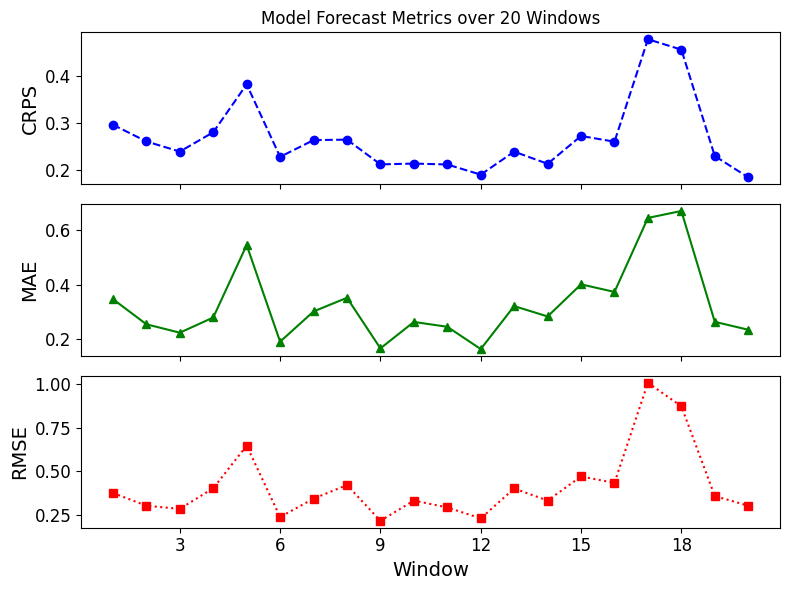

In [53]:
# Create x-values starting at 1 for each window
x_vals = np.arange(1, len(backtest_results) + 1)

# Extract the metrics from the backtest results
crps_vals = [res["crps"] for res in backtest_results]
mae_vals = [res["mae"] for res in backtest_results]
rmse_vals = [res["rmse"] for res in backtest_results]

# Create the figure with 3 subplots, sharing the x-axis
fig, axes = plt.subplots(3, figsize=(8, 6), sharex=True)

axes[0].set_title("Model Forecast Metrics over {} Windows".format(len(backtest_results)))

# Plot CRPS with blue circles and a dashed line
axes[0].plot(x_vals, crps_vals, marker='o', color='blue', linestyle='--', markersize=6)
axes[0].set_ylabel("CRPS", fontsize=14)

# Plot MAE with green triangles and a solid line
axes[1].plot(x_vals, mae_vals, marker='^', color='green', linestyle='-', markersize=6)
axes[1].set_ylabel("MAE", fontsize=14)

# Plot RMSE with red squares and a dotted line
axes[2].plot(x_vals, rmse_vals, marker='s', color='red', linestyle=':', markersize=6)
axes[2].set_ylabel("RMSE", fontsize=14)
axes[2].set_xlabel("Window", fontsize=14)

# Force x-axis tick labels to be integers
for ax in axes:
    ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.show()